In [1]:
import IO
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from scipy import signal, stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
K.set_image_data_format('channels_first') # IMPORTANT, otherwise eegnet wont work with input shape!

from scipy.stats import spearmanr

import label_generator

# free GPU memory, since it won't clear itself in one sess.
from numba import cuda 
device = cuda.get_current_device()
device.reset()

# BIDS path
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
PATH = "C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Pittsburgh\\"
vhdr_files = IO.get_all_vhdr_files(PATH)



# custom definition of cost fct.
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def EEGNet(Chans = 6, Samples = 1000, 
             dropoutRate = 0.1, kernLength = 400, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    #softmax      = Activation('softmax', name = 'softmax')(dense)
    
    linear      = Activation('linear', name = 'linear')(dense)
    
    return Model(inputs=input1, outputs=linear)

def DeepConvNet(Chans = 64, Samples = 256,
                dropoutRate = 0.0):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(1, kernel_constraint = max_norm(0.5))(flatten)
    #softmax      = Activation('softmax')(dense)
    linear      = Activation('linear', name = 'linear')(dense)
    
    return Model(inputs=input_main, outputs=linear)

def get_data_raw_combined(sub, sess, loc ,f_):
    
    start = 0
    for f in f_:
        dat, chs = IO.read_BIDS_file(os.path.join(PATH, f))
        if loc == "ECOG":
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("E") or ch.startswith("M")]
        else:
            if len([idx for idx, ch in enumerate(chs) if ch.startswith("S")]) == 0:
                continue
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("S") or ch.startswith("M")]
        if start == 0:
            start = 1
            dat_ = dat[idx__,:]
            chs_ = chs # chs might change in other runs 
        else:
            if dat[idx__].shape[0] == dat_.shape[0]:
                dat_ = np.concatenate((dat_, dat[idx__,:]), axis=1)
    if chs[-2] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-2,:]
        elif sess == "left":
            y_con = dat_[-2,:]
    if chs[-2] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-2,:]
        elif sess == "left":
            y_ips = dat_[-2,:]
    if chs[-1] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-1,:]
        elif sess == "left":
            y_con = dat_[-1,:]
    if chs[-1] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-1,:]
        elif sess == "left":
            y_ips = dat_[-1,:]
    return dat_[:-4, :], y_con, y_ips

         
def get_label_from_gen(gen_, X_, batch_size):
    """
    well this function is necessary to get the respective training and validation labels which 
        had been provided by the generator
    """
    for i in range(int(X_.shape[0]/batch_size)):
        if i == 0:
            arr = np.array(next(gen_)[1])
        else:
            arr = np.concatenate((arr, next(gen_)[1]), axis=0)
    return arr

def correlation__(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return  r_num / r_den

In [2]:
cv = KFold(n_splits=3, shuffle=False)
kernLength = 64 # half of fs
batch_size = 4000
fs_new = 128
samples = 128
fs = 1000
ONLY_GET_DATA = True

### Test EEGNet based on 1. Raw Data 2. fs=128Hz (default implementation) 3. 

In [24]:
for sub in subjects:
    for loc in ["ECOG", "STN"]:
        for sess in ["right", "left"]:
            f_ = [file for file in vhdr_files if sub in file and sess in file]
            if len(f_) == 0:
                continue
            
            X, y_con, y_ips = get_data_raw_combined(sub, sess, loc, f_)  # Raw Data 
            
            # resample data to fs_new
            y_con = signal.resample(y_con, int(y_con.shape[0]*fs_new / fs), axis=0)
            y_ips = signal.resample(y_ips, int(y_ips.shape[0]*fs_new / fs), axis=0)
            X = signal.resample(X, int(X.shape[1]*fs_new / fs), axis=1).T
            X_here = X
            
            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            hist_ = OrderedDict()
            
            for lat in ["CON", "IPS"]:
                if lat == "CON": 
                    y_ = y_con
                else:
                    y_ = y_ips
                    
                print("RUNNING subject "+str(sub)+" sess: "+str(sess)+" lat: "+ str(lat)+ "loc: "+str(loc))
                score_te = []; score_tr = []
                pr_te = []; te = []; pr_tr = []; tr = []
                for train_index, test_index in cv.split(X):
                    X_train, X_test=X_here[train_index, :], X_here[test_index, :]
                    y_train, y_test=y_[train_index], y_[test_index]

                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

                    #model  = DeepConvNet(Chans = chans, Samples = samples)
                    chans = X_train.shape[1]
                    if ONLY_GET_DATA is True:
                        continue
                    model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
                    model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
                                  metrics=[correlation__])

                    es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=10)
                    mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)
                    gen_tr = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=True, rebalanced_thr=0.1)
                    gen_val = label_generator.generator_regression(X_val, y_val, batch_size, \
                                            samples, rebalance=True, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                                         epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
                    model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})
                    
                    # get the training set label and predictions with rebalance = False
                    gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                                                samples, rebalance=False, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
                    gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    y_train_ = get_label_from_gen(gen_, X_train, batch_size)
                    
                    # get the test set label and predictions
                    gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
                    gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    y_test_ = get_label_from_gen(gen_, X_test, batch_size)

                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                    sc = metrics.r2_score(pr_test, y_test_)
                    if sc < 0: sc = 0
                    print(sc)
                    print("score test: "+str(sc))
                    score_te.append(sc)
                    
                    sc = metrics.r2_score(pr_train, y_train_)
                    if sc < 0: sc = 0
                    print("score train: "+str(sc))
                    score_tr.append(sc)
                    
                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                Yp_te[lat] = pr_te
                Yp_tr[lat] = pr_tr
                Yt_te[lat] = te
                Yt_tr[lat] = tr
                sc_te[lat] = np.mean(score_te)
                sc_tr[lat] = np.mean(score_tr)
                hist_[lat] = hist.history

            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "hist": hist_
            }

            np.save(sub + "BestChpredictions_"+str(loc)+"-ses-"+str(sess)+".npy", predict_)
            

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_iee

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RUNNING subject 000 sess: right lat: CONloc: STN
RUNNING subject 000 sess: right lat: IPSloc: STN
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
RUNNING subject 001 sess: right lat: CONloc: ECOG
RUNNING subject 001 sess: right lat: IPSloc: ECOG
Extracting paramete

Setting channel info structure...
RUNNING subject 005 sess: right lat: CONloc: STN
RUNNING subject 005 sess: right lat: IPSloc: STN
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interven

KeyboardInterrupt: 

### given this dataset (patient 000), train 1. with balancing generator

In [4]:
device = cuda.get_current_device()

In [5]:
device

<weakproxy at 0x000001E7C2674AE8 to Device at 0x000001E7C2529F48>

In [9]:
# the GPU is full and needs to be emptied first: 
device = cuda.get_current_device()
device.reset()

In [4]:
np.sum(np.array(y_train>0.1))/y_train.shape[0]

0.08275953098532679

In [5]:
np.sum(np.array(y_test>0.1))/y_test.shape[0]

0.08380301210385291

In [6]:
np.sum(np.array(y_val>0.1))/y_val.shape[0]

0.05312596242685556

In [7]:
chans

6

In [8]:
# well looks like the data is highly imbalanced

In [36]:
kernLength

64

In [37]:
samples

128

In [5]:
chans = 6

In [6]:
model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
              metrics=[correlation__])

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 6, 128)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 6, 128)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 6, 128)         32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 128)        96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 128)        64        
_________________________________________________________________
activation (Activation)      (None, 16, 1, 128)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 1, 32)         0     

In [9]:
device = cuda.get_current_device()

In [10]:
device

<weakproxy at 0x000001E7C2674AE8 to Device at 0x000001E7C2529F48>

In [11]:
REBALANCE_THR = 0.1

gen_tr = label_generator.generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = label_generator.generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4500 - correlation__: 0.1122
Epoch 00001: val_correlation__ improved from -inf to 0.55797, saving model to best_model.h5
11/11 [==============================] - 7s 609ms/step - loss: 0.4374 - correlation__: 0.1715 - val_loss: 0.3477 - val_correlation__: 0.5580
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.3222 - correlation__: 0.5429
Epoch 00002: val_correlation__ improved from 0.55797 to 0.62240, saving model to best_model.h5
11/11 [==============================] - 2s 207ms/step - loss: 0.3174 - correlation__: 0.5712 - val_loss: 0.3340 - val_correlation__: 0.6224
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.2852 - correlation__: 0.5876
Epoch 00003: val_correlation__ did not improve from 0.62240
11/11 [==============================] - 2s 205ms/step - loss: 0.2824 - correlation__: 0.6101 - val_loss: 0.3295 - val_correlation

Epoch 27/100
10/11 [==========================>...] - ETA: 0s - loss: 0.1619 - correlation__: 0.8240
Epoch 00027: val_correlation__ improved from 0.85556 to 0.86574, saving model to best_model.h5
11/11 [==============================] - 3s 252ms/step - loss: 0.1574 - correlation__: 0.8343 - val_loss: 0.1889 - val_correlation__: 0.8657
Epoch 28/100
10/11 [==========================>...] - ETA: 0s - loss: 0.1561 - correlation__: 0.8425
Epoch 00028: val_correlation__ did not improve from 0.86574
11/11 [==============================] - 3s 256ms/step - loss: 0.1519 - correlation__: 0.8512 - val_loss: 0.1913 - val_correlation__: 0.8574
Epoch 29/100
10/11 [==========================>...] - ETA: 0s - loss: 0.1561 - correlation__: 0.8436
Epoch 00029: val_correlation__ did not improve from 0.86574
11/11 [==============================] - 2s 214ms/step - loss: 0.1526 - correlation__: 0.8516 - val_loss: 0.1912 - val_correlation__: 0.8562
Epoch 30/100
10/11 [==========================>...] - ETA: 

In [12]:
samples

128

In [13]:
pr_train.shape

(44000,)

In [14]:
y_train_.shape

(44000,)

In [15]:
pr_train.shape[0]

44000

In [28]:
y_train[-pr_train.shape[0]:].shape

(44000,)

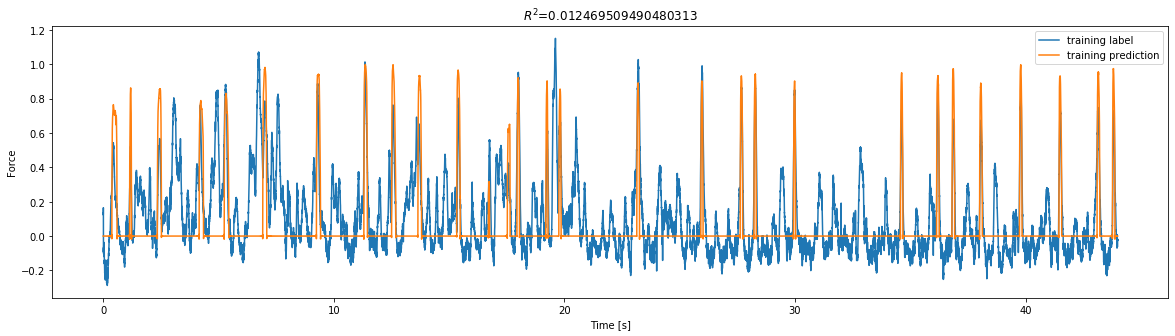

In [16]:
x_ = np.arange(0, pr_train.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_train, label="training label")
plt.plot(x_, y_train_, label="training prediction")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_train_, pr_train)))
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.legend()

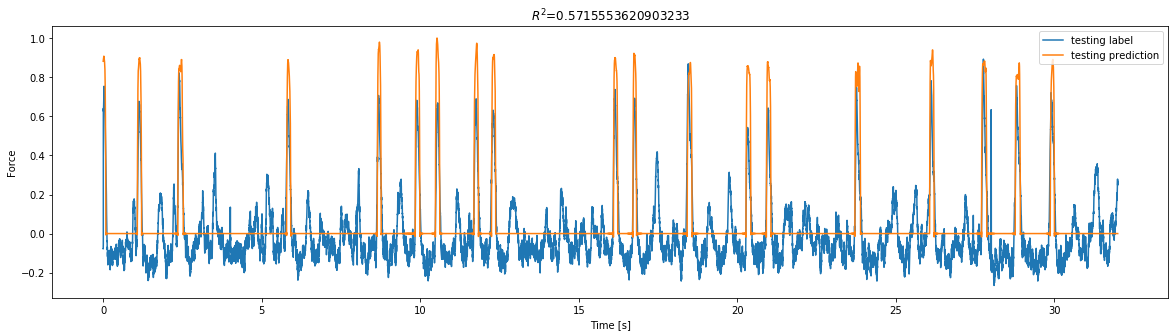

In [17]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing label")
plt.plot(x_, y_test_, label="testing prediction")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

### NOW: do not rebalance the data

In [18]:
model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
              metrics=[correlation__])

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

In [19]:
REBALANCE_THR = 0.1
with tf.device('/gpu:0'):
    gen_tr = label_generator.generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False, rebalanced_thr=REBALANCE_THR)
    gen_val = label_generator.generator_regression(X_val, y_val, batch_size, \
                        samples, rebalance=False, rebalanced_thr=REBALANCE_THR)
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.1586 - correlation__: 0.0236
Epoch 00001: val_correlation__ improved from -inf to 0.07956, saving model to best_model.h5
11/11 [==============================] - 3s 276ms/step - loss: 0.1564 - correlation__: 0.0076 - val_loss: 0.0571 - val_correlation__: 0.0796
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0807 - correlation__: 0.1903
Epoch 00002: val_correlation__ improved from 0.07956 to 0.23736, saving model to best_model.h5
11/11 [==============================] - 2s 153ms/step - loss: 0.0822 - correlation__: 0.1880 - val_loss: 0.0621 - val_correlation__: 0.2374
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0717 - correlation__: 0.2384
Epoch 00003: val_correlation__ did not improve from 0.23736
11/11 [==============================] - 2s 211ms/step - loss: 0.0736 - correlation__: 0.2182 - val_loss: 0.0562 - val_correlation

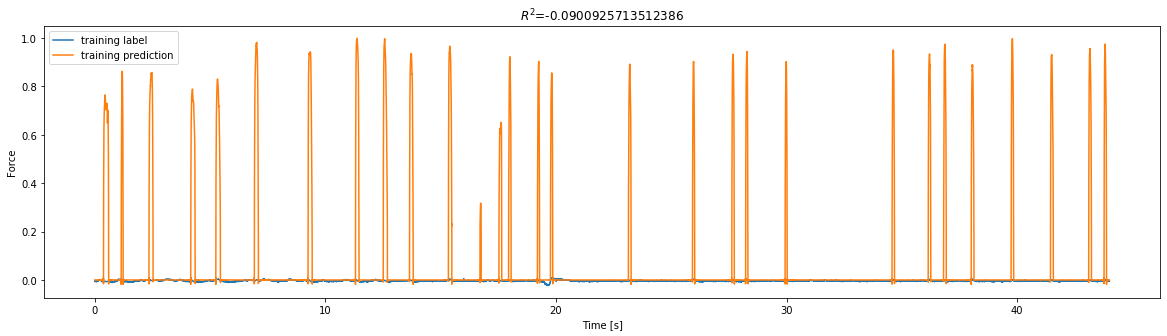

In [20]:
x_ = np.arange(0, pr_train.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_train, label="training label")
plt.plot(x_, y_train_, label="training prediction")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_train_, pr_train)))
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.legend()

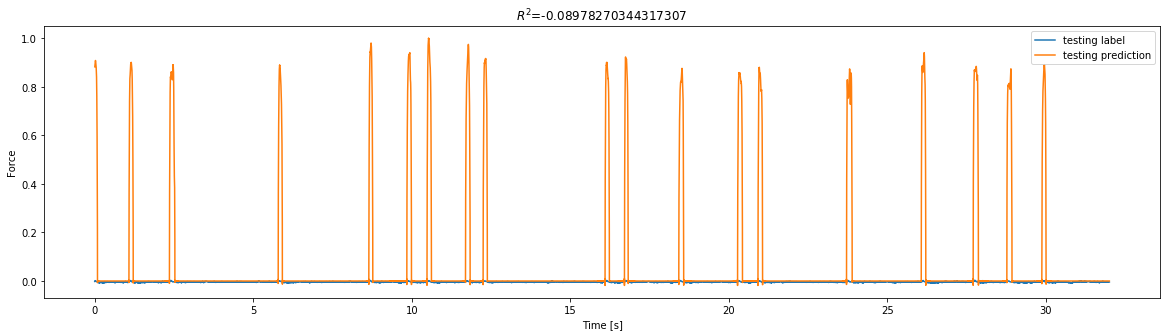

In [21]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing label")
plt.plot(x_, y_test_, label="testing prediction")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()